<a href="https://colab.research.google.com/github/SKam23/10315-Final-Project/blob/main/10315_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 10-315 ML Final Project
Created by Shaheer Aslam, Steven Kam, and Sajan Shah.

< explanation of project here >

## Library Imports

In [1]:
import importlib
import torch 
import torchvision.transforms as transforms
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from PIL import Image
from torchvision.utils import make_grid
from IPython.display import display


# CelebA Dataset Processing

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

# os.chdir('/content/drive/MyDrive/Colab Notebooks/final project/')


In [3]:
!git clone https://github.com/SKam23/SmileData.git

Cloning into 'SmileData'...
remote: Enumerating objects: 10020, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 10020 (delta 1), reused 13 (delta 1), pack-reused 10007
Receiving objects: 100% (10020/10020), 71.37 MiB | 12.27 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (10011/10011), done.


In [4]:
# load images into a dictionary for easier access
images = {}
for filename in os.listdir('./SmileData/selected_images10k/'):
    if filename.endswith('.jpg'):
        image = Image.open(os.path.join('./SmileData/selected_images10k/', filename))
        images[filename] = image


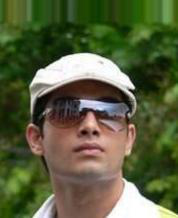

In [5]:
display(images["201426.jpg"])

In [6]:
# list_eval_partition.csv: Recommended partitioning of images into training, validation, testing sets. Images 1-162770 are training, 162771-182637 are validation, 182638-202599 are testing
# list_bbox_celeba.csv: Bounding box information for each image. "x_1" and "y_1" represent the upper left point coordinate of bounding box. "width" and "height" represent the width and height of bounding box
# list_landmarks_align_celeba.csv: Image landmarks and their respective coordinates. There are 5 landmarks: left eye, right eye, nose, left mouth, right mouth
# list_attr_celeba.csv: Attribute labels for each image. There are 40 attributes. "1" represents positive while "-1" represents negative
partition_df = pd.read_csv('./SmileData/list_eval_partition10000Smile.csv')
bbox_df = pd.read_csv('./SmileData/list_bbox_celeba10000Smile.csv')
landmarks_df = pd.read_csv('./SmileData/list_landmarks_align_celeba10000Smile.csv')
attr_df = pd.read_csv('./SmileData/list_attr_celeba10000Smile.csv')



In [7]:
merged_df = partition_df.merge(bbox_df, on='image_id').merge(landmarks_df, on='image_id').merge(attr_df, on='image_id')
train_df = merged_df[merged_df['partition'] == 0]
val_df = merged_df[merged_df['partition'] == 1]
test_df = merged_df[merged_df['partition'] == 2]


In [8]:
class CelebADataset(Dataset):
    def __init__(self, df, images):
        self.df = df
        self.images = images
        self.transform = transforms.Compose([transforms.Resize((178, 178)),transforms.ToTensor(),])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx, random = False):
        row = self.df.iloc[idx]
        image_id = row['image_id']
        image = self.images[image_id]
        image = self.transform(image)
        is_smiling = row["Smiling"] == 1
        label = 1 if is_smiling else 0
        if random:
          return image, (label, image_id)
        else:
          return image,label

In [9]:
train_dataset = CelebADataset(train_df, images)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = CelebADataset(val_df, images)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

test_dataset = CelebADataset(test_df, images)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [10]:
row = train_dataset.df.iloc[0]
row["Smiling"]

1

In [11]:
import random

def get_random_images(dataset):
    smile_images = []
    not_smile_images = []
    
    for i in range(len(dataset)):
        image, label = train_dataset.__getitem__(i, True)
        if label[0] == 1:
            smile_images.append(dataset.images[label[1]])
        else:
            not_smile_images.append(dataset.images[label[1]])
    
    print(len(smile_images))
    print(len(not_smile_images))
    smile_image = random.choice(smile_images)
    not_smile_image = random.choice(not_smile_images)

    
    return smile_image, not_smile_image


4013
4014


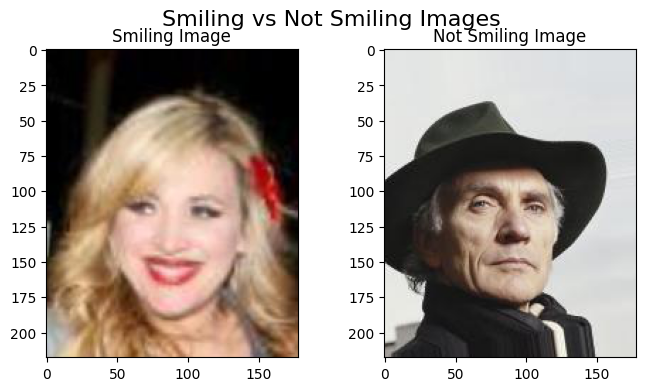

In [14]:
young_image, not_young_image = get_random_images(train_dataset)

# Create a figure and set title
fig = plt.figure(figsize=(8, 4))
fig.suptitle('Smiling vs Not Smiling Images', fontsize=16)

# Add young image to subplot 1
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(young_image)
ax1.set_title('Smiling Image')

# Add not young image to subplot 2
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(not_young_image)
ax2.set_title('Not Smiling Image')

plt.show()

# Convolutional Neural Network
< explanation >

In [16]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 44 * 44, 128)
        self.fc2 = nn.Linear(128, 2)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [19]:
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(3 * 178 * 178, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 2)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x


In [20]:
import torchvision
mobilenet = torchvision.models.mobilenet_v2()
mobilenet


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [21]:
import torch.nn.functional as F
from torchvision import models


class MobileNet(nn.Module):
    def __init__(self, pretrained=True):
        super(MobileNet, self).__init__()
        self.model = models.mobilenet_v2(pretrained=pretrained)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
    def forward(self, x):
        x = self.model.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.model.classifier(x)
        return x


In [22]:
train_dataloader.dataset[0][0].shape

torch.Size([3, 178, 178])

In [23]:
def evalDL(model, dl, lossfn):

    # figure out if the GPU is available and send model and data to it
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # use torch.no_grad() context manager to prevent gradients from accumulating in evaluation 
    # and hindering training
    with torch.no_grad():
        lossSum = 0
        nCorrect = 0
        for x, y in dl:
            x = x.to(device)
            y = y.to(device)

            yhat = model(x)

            # compute the loss and add to total (multiply by batch-size to make mean into sum)
            # by default, loss functions compute means of losses over batches
            lossSum += lossfn(yhat, y) * x.shape[0]

            # compute the number of correct and update
            predictions = torch.where(yhat > 0.5, 1, 0)
            truth = torch.where(y > 0.5, 1, 0)
            nCorrect += torch.sum(predictions == truth)

        numSamples = len(dl.dataset)
        avgLoss = lossSum / numSamples
        acc = nCorrect / numSamples
    return avgLoss.item(), acc.item()

def evaluate(model, trainDL, validDL, lossfn):
    trainLoss, trainAcc = evalDL(model, trainDL, lossfn)
    validLoss, validAcc = evalDL(model, validDL, lossfn)
    return trainLoss, trainAcc, validLoss, validAcc



In [24]:
import torch.nn.functional as F

def train(model, train_dataloader, val_dataloader, num_epochs, FCN=False):
    # define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []


    # trainLoss, trainAcc, validLoss, validAcc = evaluate(model,train_dataloader, val_dataloader, criterion)
    # train_losses.append(trainLoss)
    # train_accs.append(trainAcc)
    # val_losses.append(validLoss)
    # val_accs.append(validAcc)
    # print(f"Initial Model: train-loss={trainLoss:<4.2f} train-acc={trainAcc:<4.2f} valid-loss={validLoss:<4.2f} valid-acc={validAcc:<4.2f}")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    for epoch in range(num_epochs):
        # training loop
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        for inputs, targets in train_dataloader:
          optimizer.zero_grad()
          if FCN:
            inputs = inputs.view(inputs.size(0), -1)  # flatten input
          inputs = inputs.to(device)
          targets = targets.to(device)
          outputs = model(inputs)
          _, predicted = torch.max(outputs.data, 1)
          targets_onehot = F.one_hot(targets, num_classes=2).float().to(device)  # convert targets to one-hot format
          loss = criterion(outputs, targets)
          loss.backward()
          optimizer.step()
          train_loss += loss.item() * inputs.size(0)
          train_total += targets.size(0)
          train_correct += (predicted == targets).sum().item()
        train_loss /= len(train_dataloader.dataset)
        train_losses.append(train_loss)
        train_acc = train_correct / train_total
        train_accs.append(train_acc)

        # validation loop
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, targets in val_dataloader:
                if FCN:
                  inputs = inputs.view(inputs.size(0), -1)  # flatten input
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()
            val_loss /= len(val_dataloader.dataset)
            val_losses.append(val_loss)
            val_acc = val_correct / val_total
            val_accs.append(val_acc)

        # print progress
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    return model, train_losses, val_losses, train_accs, val_accs


In [25]:
def trainFCN(model, train_dataloader, val_dataloader, num_epochs):
    # define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    for epoch in range(num_epochs):
        # training loop
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        for inputs, targets in train_dataloader:
          optimizer.zero_grad()
          inputs = inputs.view(inputs.size(0), -1)  # flatten input
          inputs = inputs.to(device)
          targets = targets.to(device)
          outputs = model(inputs)
          _, predicted = torch.max(outputs.data, 1)
          targets_onehot = F.one_hot(targets, num_classes=2).float().to(device)  # convert targets to one-hot format
          loss = criterion(outputs, targets)
          loss.backward()
          optimizer.step()
          train_loss += loss.item() * inputs.size(0)
          train_total += targets.size(0)
          train_correct += (predicted == targets).sum().item()
        train_loss /= len(train_dataloader.dataset)
        train_losses.append(train_loss)
        train_acc = train_correct / train_total
        train_accs.append(train_acc)

        # validation loop
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, targets in val_dataloader:
                inputs = inputs.view(inputs.size(0), -1)  # flatten input
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()
            val_loss /= len(val_dataloader.dataset)
            val_losses.append(val_loss)
            val_acc = val_correct / val_total
            val_accs.append(val_acc)

        # print progress
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    return model, train_losses, val_losses, train_accs, val_accs


In [26]:
model, train_losses, val_losses, train_accs, val_accs = train(CNN(), train_dataloader,val_dataloader,10)

Epoch [1/10], Train Loss: 0.7069, Train Acc: 0.5789, Val Loss: 0.5474, Val Acc: 0.7318
Epoch [2/10], Train Loss: 0.4323, Train Acc: 0.8042, Val Loss: 0.2876, Val Acc: 0.8784
Epoch [3/10], Train Loss: 0.2982, Train Acc: 0.8793, Val Loss: 0.2597, Val Acc: 0.8853
Epoch [4/10], Train Loss: 0.2442, Train Acc: 0.8998, Val Loss: 0.2697, Val Acc: 0.8764
Epoch [5/10], Train Loss: 0.2093, Train Acc: 0.9134, Val Loss: 0.2627, Val Acc: 0.8824
Epoch [6/10], Train Loss: 0.1881, Train Acc: 0.9240, Val Loss: 0.2709, Val Acc: 0.8794
Epoch [7/10], Train Loss: 0.1631, Train Acc: 0.9333, Val Loss: 0.2841, Val Acc: 0.8883
Epoch [8/10], Train Loss: 0.1349, Train Acc: 0.9443, Val Loss: 0.3100, Val Acc: 0.8923
Epoch [9/10], Train Loss: 0.1118, Train Acc: 0.9568, Val Loss: 0.3171, Val Acc: 0.8833
Epoch [10/10], Train Loss: 0.0965, Train Acc: 0.9646, Val Loss: 0.3888, Val Acc: 0.8794


In [27]:
FCNmodel, FCNtrain_losses, FCNval_losses, FCNtrain_accs, FCNval_accs =   train(FCN(), train_dataloader,val_dataloader,10, True)

Epoch [1/10], Train Loss: 1.2306, Train Acc: 0.5100, Val Loss: 0.6862, Val Acc: 0.5633
Epoch [2/10], Train Loss: 0.6879, Train Acc: 0.5287, Val Loss: 0.6652, Val Acc: 0.6421
Epoch [3/10], Train Loss: 0.6911, Train Acc: 0.5179, Val Loss: 0.6928, Val Acc: 0.5174
Epoch [4/10], Train Loss: 0.6931, Train Acc: 0.5181, Val Loss: 0.6894, Val Acc: 0.5842
Epoch [5/10], Train Loss: 0.6880, Train Acc: 0.5322, Val Loss: 0.6943, Val Acc: 0.4985
Epoch [6/10], Train Loss: 0.6929, Train Acc: 0.5121, Val Loss: 0.6935, Val Acc: 0.4985
Epoch [7/10], Train Loss: 0.6932, Train Acc: 0.4978, Val Loss: 0.6932, Val Acc: 0.4945
Epoch [8/10], Train Loss: 0.6932, Train Acc: 0.5006, Val Loss: 0.6932, Val Acc: 0.5015
Epoch [9/10], Train Loss: 0.6933, Train Acc: 0.4937, Val Loss: 0.6932, Val Acc: 0.5015
Epoch [10/10], Train Loss: 0.6933, Train Acc: 0.4941, Val Loss: 0.6932, Val Acc: 0.4955


In [28]:
pFCNmodel, pFCNtrain_losses, pFCNval_losses, pFCNtrain_accs, pFCNval_accs = train(MobileNet(True), train_dataloader,val_dataloader,10, False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 62.5MB/s]


Epoch [1/10], Train Loss: 0.5518, Train Acc: 0.8669, Val Loss: 0.2059, Val Acc: 0.9123
Epoch [2/10], Train Loss: 0.1818, Train Acc: 0.9239, Val Loss: 0.2426, Val Acc: 0.9073
Epoch [3/10], Train Loss: 0.1382, Train Acc: 0.9423, Val Loss: 0.3045, Val Acc: 0.8943
Epoch [4/10], Train Loss: 0.1110, Train Acc: 0.9556, Val Loss: 0.2011, Val Acc: 0.9182
Epoch [5/10], Train Loss: 0.1003, Train Acc: 0.9595, Val Loss: 0.1963, Val Acc: 0.9222
Epoch [6/10], Train Loss: 0.0680, Train Acc: 0.9738, Val Loss: 0.3121, Val Acc: 0.8973
Epoch [7/10], Train Loss: 0.0612, Train Acc: 0.9787, Val Loss: 0.8304, Val Acc: 0.8195
Epoch [8/10], Train Loss: 0.0574, Train Acc: 0.9752, Val Loss: 0.3211, Val Acc: 0.9153
Epoch [9/10], Train Loss: 0.0508, Train Acc: 0.9813, Val Loss: 0.3140, Val Acc: 0.9123
Epoch [10/10], Train Loss: 0.0379, Train Acc: 0.9862, Val Loss: 0.2886, Val Acc: 0.9182


In [29]:
def plotStatistics(pretrained, epochs, trainLosses, trainAccs, validLosses, validAccs):
    fig, axes = plt.subplots(1,2)
    xdata = np.arange(epochs)
    
    # plot the losses
    axis = axes[0]
    axis.plot(xdata, trainLosses, label="Train")
    axis.plot(xdata, validLosses, label="Valid")
    axis.set_xlabel("# Epochs")
    axis.set_ylabel("Average Loss")
    axis.set_title(f"Loss w/ Pretrained: {pretrained}")
    axis.grid()
    axis.legend()
    
    # plot the accuracies
    axis = axes[1]
    axis.plot(xdata, trainAccs, label="Train")
    axis.plot(xdata, validAccs, label="Valid")
    axis.set_xlabel("# Epochs")
    axis.set_ylabel("Accuracy")
    axis.set_title(f"Accuracy w/ Pretrained: {pretrained}")
    axis.grid()
    axis.legend()

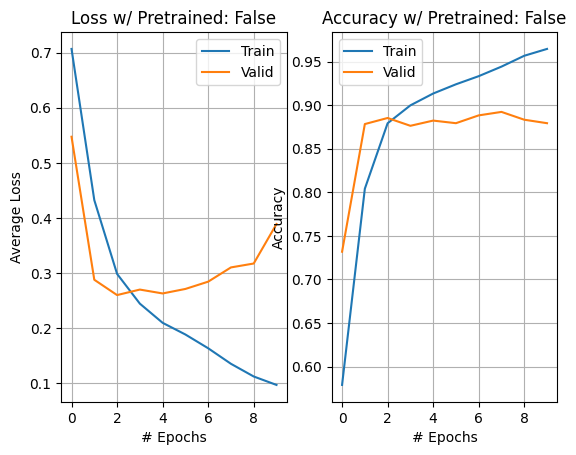

In [30]:
plotStatistics(False, 10, train_losses, train_accs, val_losses, val_accs)


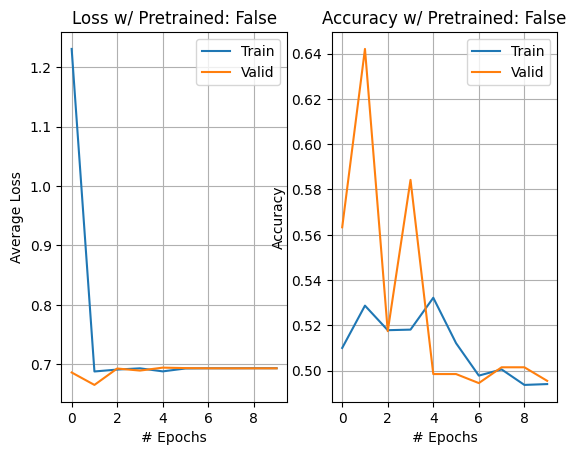

In [31]:
plotStatistics(False, 10, FCNtrain_losses, FCNtrain_accs, FCNval_losses, FCNval_accs)


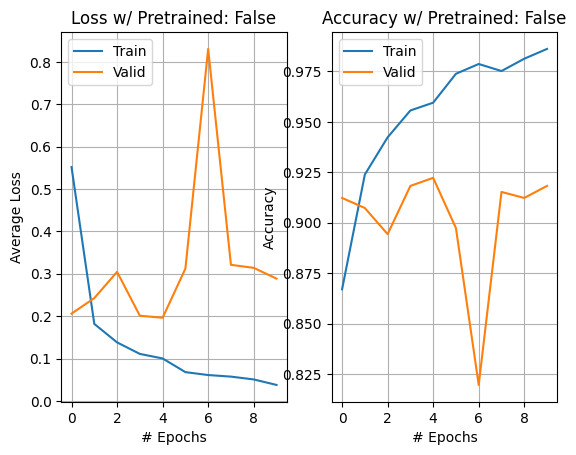

In [32]:
plotStatistics(False, 10, pFCNtrain_losses, pFCNtrain_accs, pFCNval_losses, pFCNval_accs)


# Try it yourself!


## Colab Script to take photo


Following notebook: https://colab.research.google.com/drive/1QnC7lV7oVFk5OZCm75fqbLAfD9qBy9bw?usp=sharing#scrollTo=09b_0FAnUa9y

In [33]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [34]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [35]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)

In [36]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [37]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [38]:
from tensorflow.keras.utils import img_to_array

In [102]:
# start streaming video from webcam
video_stream()
# creating device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # do prediction on img
    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray)
    # get face bounding box for overlay
    for (x,y,w,h) in faces:
      # code for writing smiling/not smiling
      roi = cv2.resize(img[y:y + h, x:x + w], (178, 178))
      # roi = np.stack((roi,) * 3, axis=-1)
      roi = np.transpose(roi, (2, 0, 1))
      roi = roi.astype('float') / 255.0
      roi = img_to_array(roi)
      roi = np.expand_dims(roi, axis = 0)
      roi = torch.Tensor(roi).to(device)
      res = model(roi)
      _, predicted = torch.max(res.data, 1)
      if (predicted.item()):
        cv2.putText(bbox_array, "Smiling", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
        bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(0,255,0),2)
      else:
        cv2.putText(bbox_array, "Not Smiling", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 0, 0), 2)
        bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)

    

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

Run the following cell to take a photo and test your image in the network!